# Fandango Seating Analysis

Create a heat-map of a theater seating-chart indicating the average demand of a seat given its position relative to the screen. Do this using a sort of Gaussian kernel density estimation where the value of a position in a theater corresponds to the average fraction of open seats in the theater when a seat at that position is reserved.

**Seating Convention Notes:**

* Every seat is labeled with a letter (indicating row) and a 1-indexed number (indicating column).
* Row letters increase from the **front** to the **back** of the theater (from closest to farthest from the screen).
* Column numbers increase from **house right** to **house left** (i.e., right to left when the screen is in front of you).
* Not every row is guaranteed to have the same number of columns.
* Sometimes, a row may have missing column numbers due to walkways, handicap spaces, or unusual seating arrangements.

**Visualization Notes:**

* If a column number is missing for a given row in a seating chart, I will assume that the lack of this column number accounts for a physical gap in the seating chart. Thus, I will take the number of columns in a row to be equal to the highest column number in that row specified by the seating chart. All resulting gaps will be treated as seats with 0 demand.
* Since theaters come in many shapes and sizes, I will map all seating charts onto a standardized square grid. This mapping process is 2 steps:
  1. Map the seats onto a rectangular space such that if a theater has N rows and M columns, the rectangle can be populated with N * M square-packed circles of equal radius (where each circle represents 1 seat located approximately at the circle's center).
    * **How can we account for leg-room?**
  2. Then stretch the rectangle (and the circles that fill it) vertically or horizontally so that the seats fill the space of a square.
* I will assume that every seat in a theater is the same size.
* I will assume that each row is centered along the axis which divides the theater into a left and right half. Thus, if a row has fewer columns than the highest possible number of columns in that theater, the permanently unoccupied space at the left and right edges of that row will be be treated as seats with 0 demand.

In [45]:
import os
import json

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Load data

In [2]:
data_dir = "data"
movies_dir = "movies" 
movie_dir = "Ant-Man and the Wasp"
theater_dir = "AABTB - Edwards Irvine Spectrum 21 IMAX & RPX"
file_name = "2018-07-07_2030_152615700.txt"

file_path = "../" + "/".join([data_dir, movies_dir, movie_dir, theater_dir, file_name])

with open(file_path, "r") as fp:
    data = fp.readlines()
    
data = [json.loads(x.strip().replace("'", '"')) for x in data]
config = data[0]
snapshots = data[1:]

### Process Seat Configuration Data

In [3]:
seat_labels = config["seats"]
seat_let_num = [[x[0], int(x[1:])] for x in seat_labels]
letters = sorted(list(set([x[0] for x in seat_let_num])))
letter_to_row = dict(zip(letters, [i + 1 for i in range(len(letters))]))

seat_row_col = [[letter_to_row[x[0]], x[1]] for x in seat_let_num]

num_seats = len(seat_row_col)
num_rows = len(letters)
num_cols = [max([x[1] for x in seat_row_col if x[0] == i + 1]) for i in range(num_rows)]

### Process seat snapshot data

In [133]:
reserved = [snap[1]["R"] for snap in snapshots]

seat_sets = []
seat_set = set()

for r in reserved:
    
    new_seat_set = set(r)
    
    added_seats = new_seat_set - seat_set
    
    if added_seats:
        seat_set = seat_set.union(added_seats)
        frac_remaining = 1 - (len(seat_set) / num_seats)
        seat_sets.append([frac_remaining, added_seats])

def seat_row_col_to_rect_xy(seats, num_rows, num_cols, leg_room=2):
    
    # seats = np.array([row, col, demand]), with 1-indexed row and col values
    
    row = seats[:, 0]
    col = seats[:, 1]
    
    num_cols = np.array(num_cols)
    
    x = -(col - 1) + (num_cols[row.astype("int") - 1] - 1)/2
    y = (-(row - 1) + (num_rows - 1)/2) * leg_room
    
    pos = np.empty_like(seats)
    pos[:] = seats
    pos[:, 0] = x
    pos[:, 1] = y
    
    return pos
        
seat_reservations = np.array([[*seat_row_col[s], x[0]] for x in seat_sets for s in x[1]])

leg_room = 2
seat_positions = seat_row_col_to_rect_xy(seat_reservations, num_rows, num_cols, leg_room)
seat_config_pos = seat_row_col_to_rect_xy(np.array(seat_row_col), num_rows, num_cols, leg_room)

### Plot rectangular heat-map

In [151]:
seat_x_max = max(num_cols)/2
seat_y_max = (num_rows/2) * leg_room

x_min = -(seat_x_max + leg_room)
x_max = -x_min
y_min = -(seat_y_max + leg_room) 
y_max = seat_y_max + 2 * leg_room

resolution = 200

x = np.linspace(x_min, x_max, resolution)
y = np.linspace(y_min, y_max, resolution)
s = np.repeat(1, len(seat_positions))

X, Y, _ = np.meshgrid(x, y, s)

seat_width = 1
p = 5

X_0 = seat_positions[:, 0]
Y_0 = seat_positions[:, 1]
d = seat_positions[:, 2]

D_individual = (d ** p) * np.exp(-((X - X_0)**2 + (Y - Y_0)**2) / seat_width ** 2)
D = np.mean(D_individual, axis = 2)

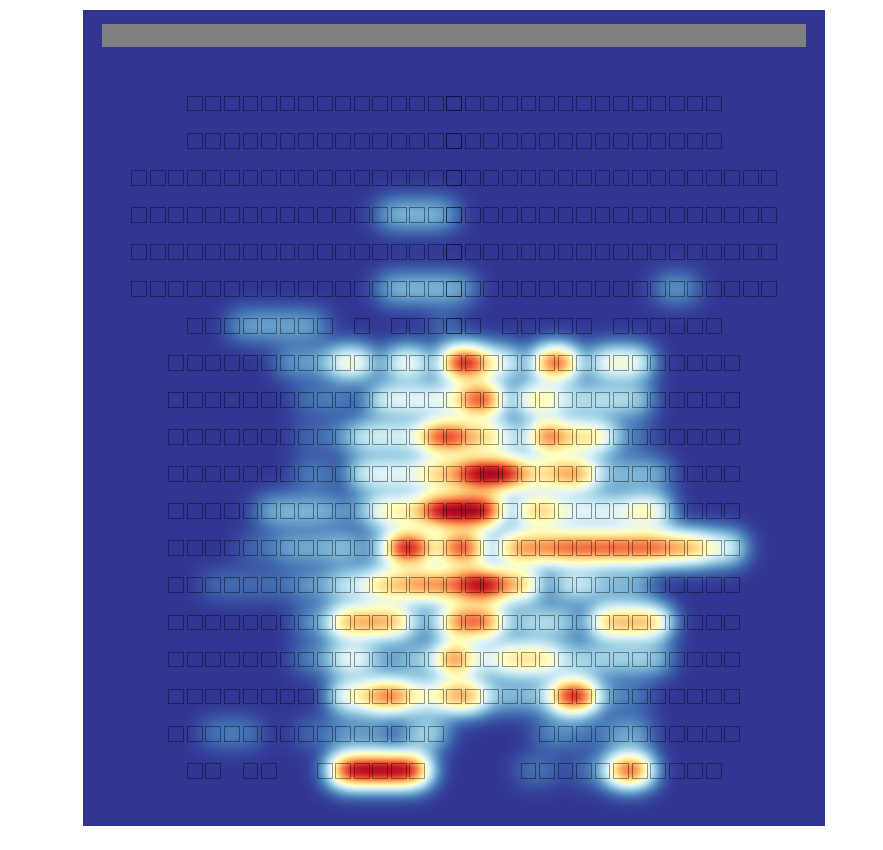

In [155]:
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(1, 1, 1)

ax.contourf(X[:, :, 0], Y[:, :, 0], D, 1000, cmap = "RdYlBu_r")

seat_scaler = 0.8
seat_color = "black"
screen_color = "gray"
w = seat_scaler * seat_width
h = w
seat_patches_xy = seat_config_pos - np.array([w, h])/2
alpha = 0.4

for p in seat_patches_xy:
    ax.add_patch(patches.Rectangle(tuple(p), 
                                   width = w, 
                                   height = h, 
                                   ec = seat_color, 
                                   alpha = alpha, 
                                   fill = None))

ax.add_patch(patches.Rectangle((x_min + leg_room/2, y_max - leg_room), 
                               width = 2 * x_max - leg_room,
                               height = seat_width * 1.25,
                               fc = screen_color))
    
ax.set_xlim(-x_max, x_max)
ax.set_ylim(-y_max, y_max)
ax.axis("equal")
ax.axis("off")

save_fig = True
if save_fig == True:

    image_dir = "../images/%s" % movie_dir
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
    image_name = "%s.png" % file_name.split(".")[0]
    
    plt.savefig("/".join([image_dir, image_name]), 
                dpi = 600, 
                bbox_inches = "tight",
                pad_inches = 0,
                transparent = True)

plt.show()
plt.gcf().clear()